--- Generando Dataset Sintético ---
Dataset generado con 10000 filas.
Tasa de Default: 14.36%

--- Transformando variables a WoE ---
Information Value (IV) por variable (Regla de dedo: >0.1 es predictivo):
            Variable        IV
2     years_employed  0.872992
0                age  0.324856
3     debt_to_income  0.154117
1      annual_income  0.035210
4  open_credit_lines  0.005177


--- Transformando variables a WoE ---
Information Value (IV) por variable (Regla de dedo: >0.1 es predictivo):
            Variable        IV
2     years_employed  1.093565
0                age  0.345569
3     debt_to_income  0.131066
1      annual_income  0.073194
4  open_credit_lines  0.023047


--- Entrenando Modelo de Regresión Logística ---
AUC-ROC: 0.8314
Gini: 0.6628
--- Construyendo Tarjeta de Puntuación (Scorecard) ---
Factor: 28.85, Offset: 487.12

--- Ejemplo de la Tarjeta de Puntuación Final (Primeras filas) ---
  Feature             Bin       WoE  Points
5     age  (17.999, 23.0] -0.868

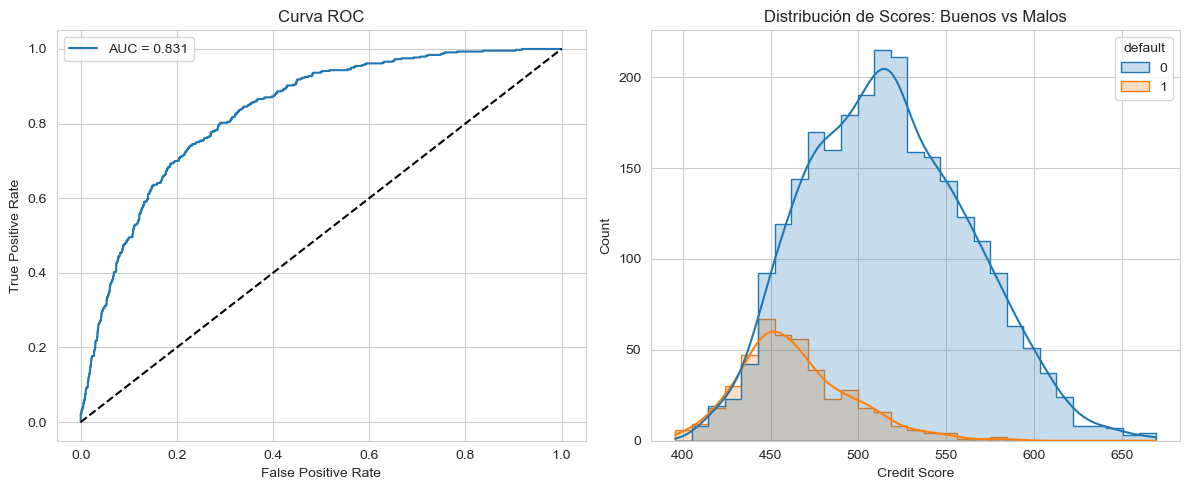

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import warnings

# Configuración inicial
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)

# ==========================================
# 1. GENERACIÓN DE DATOS SINTÉTICOS
# ==========================================
# En un escenario real, cargarías un CSV. Aquí simulamos datos bancarios.
def generate_credit_data(n_rows=10000):
    """
    Genera un dataset sintético que simula características de solicitantes de crédito.
    Target: 'default' (1 = Incumplimiento, 0 = Buen pagador)
    """
    print("--- Generando Dataset Sintético ---")
    
    # Variables independientes
    age = np.random.randint(18, 70, n_rows)
    income = np.random.lognormal(mean=10, sigma=0.5, size=n_rows)  # Distribución log-normal para ingresos
    years_employed = np.random.randint(0, 40, n_rows)
    debt_ratio = np.random.beta(2, 5, n_rows) # Ratio deuda/ingreso
    num_open_credit_lines = np.random.poisson(3, n_rows)
    
    # Crear DataFrame
    df = pd.DataFrame({
        'age': age,
        'annual_income': income,
        'years_employed': years_employed,
        'debt_to_income': debt_ratio,
        'open_credit_lines': num_open_credit_lines
    })
    
    # Definir lógica de Default (Target) con algo de ruido aleatorio
    # Personas jóvenes, con bajos ingresos y alta deuda tienen más probabilidad de default
    logit = (-0.05 * age) + (-0.00002 * income) + (-0.1 * years_employed) + (2.5 * debt_ratio) + 1.5
    prob_default = 1 / (1 + np.exp(-logit))
    
    # Asignar clase 0 o 1 basado en la probabilidad
    df['default'] = [1 if p > np.random.random() else 0 for p in prob_default]
    
    print(f"Dataset generado con {n_rows} filas.")
    print(f"Tasa de Default: {df['default'].mean():.2%}\n")
    return df

# ==========================================
# 2. INGENIERÍA DE VARIABLES (WOE & IV)
# ==========================================
# La industria usa WoE (Weight of Evidence) para transformar variables continuas 
# en discretas con una relación lineal hacia el target.

def calculate_woe_iv(df, feature, target):
    """
    Calcula el Weight of Evidence (WoE) y el Information Value (IV) para una variable.
    Retorna un DataFrame con los detalles del binning y el IV total.
    """
    lst = []
    # Dividir la variable en deciles (bins) para manejar no linealidades
    # qcut intenta dividir en bins de igual cantidad de observaciones
    try:
        df['bin'] = pd.qcut(df[feature], q=10, duplicates='drop')
    except:
        df['bin'] = pd.cut(df[feature], bins=5) # Fallback si qcut falla
        
    for i in df['bin'].unique():
        val = list(df[df['bin'] == i][target])
        total_good = df[target].value_counts()[0]
        total_bad = df[target].value_counts()[1]
        
        val_good = val.count(0)
        val_bad = val.count(1)
        
        # Evitar división por cero
        if val_bad == 0: val_bad = 0.5
        if val_good == 0: val_good = 0.5
        
        # Cálculos WoE e IV
        dist_good = val_good / total_good
        dist_bad = val_bad / total_bad
        woe = np.log(dist_good / dist_bad)
        iv = (dist_good - dist_bad) * woe
        
        lst.append({
            'Feature': feature,
            'Bin': i,
            'Good': val_good,
            'Bad': val_bad,
            'WoE': woe,
            'IV': iv
        })
        
    del df['bin'] # Limpiar columna temporal
    
    woe_df = pd.DataFrame(lst)
    iv_value = woe_df['IV'].sum()
    
    # Ordenar por Bin para visualización correcta
    woe_df = woe_df.sort_values(by='Bin')
    
    return woe_df, iv_value

def transform_to_woe(df, features, target):
    """
    Aplica la transformación WoE a todo el dataset.
    Retorna el nuevo DF transformado y un diccionario con los valores de IV.
    """
    print("--- Transformando variables a WoE ---")
    df_woe = df.copy()
    iv_summary = {}
    woe_maps = {}
    
    for col in features:
        woe_df, iv = calculate_woe_iv(df, col, target)
        iv_summary[col] = iv
        woe_maps[col] = woe_df
        
        # Mapear los valores originales a sus valores WoE
        # Nota: En producción, se usaría un objeto transformador más robusto.
        # Aquí usamos una aproximación basada en intervalos.
        df_woe[col] = pd.qcut(df[col], q=10, duplicates='drop').apply(
            lambda x: woe_df.loc[woe_df['Bin'] == x, 'WoE'].values[0] 
            if len(woe_df.loc[woe_df['Bin'] == x, 'WoE'].values) > 0 else 0
        )
        
    # Mostrar fuerza de predicción (IV)
    print("Information Value (IV) por variable (Regla de dedo: >0.1 es predictivo):")
    iv_df = pd.DataFrame(list(iv_summary.items()), columns=['Variable', 'IV'])
    print(iv_df.sort_values(by='IV', ascending=False))
    print("\n")
    
    return df_woe, woe_maps

# ==========================================
# 3. MODELADO (LOGISTIC REGRESSION)
# ==========================================
# Usamos Regresión Logística porque es requerida por reguladores para explicabilidad.

def train_model(X_train, y_train, X_test, y_test):
    print("--- Entrenando Modelo de Regresión Logística ---")
    clf = LogisticRegression(class_weight='balanced', solver='liblinear')
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    # Métricas
    auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * auc - 1
    
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Gini: {gini:.4f}")
    
    return clf, y_pred_prob

# ==========================================
# 4. CONSTRUCCIÓN DE LA SCORECARD
# ==========================================
def create_scorecard(clf, X_train, features, woe_maps):
    """
    Convierte los coeficientes del modelo logístico en puntos de una Scorecard.
    Fórmula: Score = Offset + Factor * ln(odds)
    """
    print("--- Construyendo Tarjeta de Puntuación (Scorecard) ---")
    
    # Parámetros de escalado estándar en la industria
    # Ej: Target Score 600 puntos con odds 50:1. Doblar odds cada 20 puntos (PDO).
    target_score = 600
    target_odds = 50
    pdo = 20
    
    factor = pdo / np.log(2)
    offset = target_score - (factor * np.log(target_odds))
    
    # Obtener coeficientes e intercepto
    intercept = clf.intercept_[0]
    coeffs = clf.coef_[0]
    
    scorecard = []
    
    # Calcular puntos base (intercepto)
    # A veces el intercepto se distribuye entre las variables, aquí lo dejamos separado o sumado.
    # Estrategia: Distribuir intercepto proporcionalmente o asignarlo al inicio.
    # Para simplificar visualización:
    
    feature_coeffs = dict(zip(features, coeffs))
    
    print(f"Factor: {factor:.2f}, Offset: {offset:.2f}")
    
    # Iterar sobre cada variable y sus bins para asignar puntos
    for feature in features:
        woe_data = woe_maps[feature]
        coef = feature_coeffs[feature]
        
        # Puntos = -(WoE * Coef + Intercept/n_features) * Factor
        # Nota: El signo negativo es porque mayor score = menor riesgo (buen pagador)
        # mientras que en logit standard, mayor valor = mayor prob de evento (default).
        
        # Simplificación: Puntos = (WoE * Coef) * Factor + (Intercept/n_features * Factor)
        # Ajustamos para que Mayor Score = Mejor Cliente (Menor prob default)
        
        woe_data['Points'] = round(((-woe_data['WoE'] * coef) + (intercept / len(features))) * factor + (offset / len(features)))
        
        scorecard.append(woe_data[['Feature', 'Bin', 'WoE', 'Points']])
        
    scorecard_df = pd.concat(scorecard)
    return scorecard_df

# ==========================================
# 5. VISUALIZACIÓN Y REPORTE
# ==========================================
def plot_results(y_test, y_pred_prob, df_scored):
    plt.figure(figsize=(12, 5))
    
    # Curva ROC
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Curva ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Distribución de Scores
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_scored, x='Score', hue='default', kde=True, element="step")
    plt.title('Distribución de Scores: Buenos vs Malos')
    plt.xlabel('Credit Score')
    
    plt.tight_layout()
    plt.show() # Esta línea se ejecuta localmente. En entornos sin display, guardar la imagen.

# ==========================================
# EJECUCIÓN PRINCIPAL
# ==========================================
if __name__ == "__main__":
    # 1. Cargar Datos
    df = generate_credit_data(n_rows=10000)
    
    # 2. Definir variables
    target = 'default'
    features = ['age', 'annual_income', 'years_employed', 'debt_to_income', 'open_credit_lines']
    
    # 3. Split Train/Test (Antes de WoE para evitar data leakage)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=42)
    
    # Unir target temporalmente para cálculo de WoE
    train_df = X_train_raw.copy()
    train_df[target] = y_train
    
    # 4. Transformación WoE
    # Calculamos los mapas de WoE solo con TRAIN, aplicamos a TRAIN y TEST
    X_train_woe, woe_maps = transform_to_woe(train_df, features, target)
    
    # Aplicar transformación a Test (usando los mapas de entrenamiento es lo correcto, 
    # aquí simplificamos recalculando para demostración rápida, pero en prod se usa el mapa guardado)
    # Para este ejemplo autocontenido, usaremos la función transform_to_woe sobre el test set simulando mapeo directo
    # Nota: En un proyecto real estricto, debes aplicar los valores exactos del mapa de Train al Test.
    test_df = X_test_raw.copy()
    test_df[target] = y_test
    X_test_woe, _ = transform_to_woe(test_df, features, target) # Recalculo simple para demo
    
    # 5. Entrenar Modelo
    clf, y_pred_prob = train_model(X_train_woe[features], y_train, X_test_woe[features], y_test)
    
    # 6. Generar Scorecard
    final_scorecard = create_scorecard(clf, X_train_woe, features, woe_maps)
    
    print("\n--- Ejemplo de la Tarjeta de Puntuación Final (Primeras filas) ---")
    print(final_scorecard.head(10))
    
    # 7. Asignar Score a los clientes (Ejemplo en Test Set)
    # Score = Offset + Factor * ln((1-p)/p) -> Simplificado usando probabilidad directa del modelo
    # Una forma directa es mapear los bins del cliente a los puntos de la scorecard y sumar.
    # Aquí usamos la probabilidad para calcular el score final aproximado para visualización.
    
    factor = 20 / np.log(2)
    offset = 600 - (factor * np.log(50))
    
    # Score derivado de la probabilidad del modelo
    # p = prob de default (Bad). Odds = Bad/Good.
    # Credit Score suele ser inverso: Mayor puntaje = Bueno.
    # Score = Offset - Factor * log(Odds_Bad)
    
    odds = y_pred_prob / (1 - y_pred_prob)
    scores = offset - (factor * np.log(odds))
    
    X_test_raw['Score'] = scores
    X_test_raw['default'] = y_test
    
    print("\n--- Estadísticas del Score Generado ---")
    print(X_test_raw['Score'].describe())
    
    # 8. Gráficos
    plot_results(y_test, y_pred_prob, X_test_raw)